In [28]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----'
}

linestyle = {
    'Vector': '-',
    'Skiplist': '-',
    'Hashskiplist': '-.',
    'Hashlinklist': '..'
}

alpha = {
    'Vector': 1,
    'Skiplist': 0.8,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

color = {
    'Vector': 'darkslateblue',
    'Skiplist': 'slategray',
    'Hashskiplist': 'darkkhaki',
    'Hashlinklist': 'chocolate'
    # 'Vector': 'black',
    # 'Skiplist': 'black',
    # 'Hashskiplist': 'black',
    # 'Hashlinklist': 'black'
}

linewidth = {
    'Vector': 1,
    'Skiplist': 1,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

edgecolor = {
    'Vector': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

label = {
    'Vector': 'vector',
    'Skiplist': 'skiplist',
    'Hashskiplist': 'hash skiplist',
    'Hashlinklist': 'hash linklist'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

In [29]:
def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": color.get(key.capitalize()) or "None",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            # "linestyle": linestyle.get(key.capitalize()),
            # "hatch": hatch.get(key.capitalize()),
            "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [30]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}"
    )


def get_log_file_path(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}"
    return f"{get_exp_dirname(query_type, selectivity, entry_size)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}"

In [31]:
def plot_vector_skip_list_range(
    vec_df: pd.DataFrame, skip_df: pd.DataFrame, num: int = 0
):

    fig_size = (5, 3.5)

    if num == 0:
        num = len(vec_df)

    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(
        vec_df.index[:num],
        vec_df["TimeTaken"][:num] / 1000,
        color=color["Vector"],
        label="vector",
    )
    ax.plot(
        skip_df.index[:num],
        skip_df["TimeTaken"][:num] / 1000,
        color=color["SkipList"],
        label="skiplist",
    )
    ax.set_xlabel("range query number")
    ax.set_ylabel("latency (ms)")
    ax.set_ylim(bottom=0)
    ax.legend()
    plt.show()

In [32]:
def plot_subplots_vector_skip_list_range(
    df_pairs: List[Tuple[pd.DataFrame, pd.DataFrame]],
    titles: List[str],
    annotatepos: List[Dict[str, str]],
    num: int = 0,
):
    fig_size = (10, 3.5)

    fig, ax = plt.subplots(1, len(d), figsize=fig_size)
    for i, tup in enumerate(df_pairs, start=0):
        df1, df2 = tup
        ax[i].plot(
            df1.index[:num],
            df1["TimeTaken"][:num] / 1000,
            label="vector",
            **get_properties("Vector"),
        )
        ax[i].plot(
            df2.index[:num],
            df2["TimeTaken"][:num] / 1000,
            label="skiplist",
            **get_properties("Skiplist"),
        )
        ax[i].set_xlabel("range query number")
        ax[i].set_ylabel("latency (ms)")
        ax[i].set_ylim(bottom=0)
        ax[i].set_title(f"({alphabets[i]}) " + titles[i])
        x, y, step = annotatepos[i]["x"], annotatepos[i]["y"], annotatepos[i]["step"]
        ax[i].annotate(f"avg time", xy=(x, y))
        ax[i].annotate(
            f"    vector: {(list_vec_df[i][:num]/1000).mean()['TimeTaken']:.2f} $\mathit{{m}}s$",
            xy=(x + 4, y - step),
        )
        ax[i].annotate(
            f"    skip list: {(list_skip_df[i][:num]/1000).mean()['TimeTaken']:.2f} $\mathit{{m}}s$",
            xy=(x + 4, y - step * 2),
        )

        ax[i].legend()

    plt.show()

In [33]:
def prepare_dataframe(log_file_path: str, key: str="RangeQueryTime: ") -> pd.DataFrame:
    ff = open(log_file_path, "r")
    range_quereis = []

    for line in ff.readlines():
        if key in line:
            range_quereis.append(float(line.split(" ")[1]))
    
    return pd.DataFrame(range_quereis, columns=["TimeTaken"])


In [38]:
query_type = "RQ-prefix-based-rq"
entry_size = 64
memtables = ["Vector", "Skiplist", "HashSkiplist", "HashLinklist"]
inserts = 140000
point_queries = 0
range_queries = 200
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
prefixlen = 2
bucket_count = 100000

selectivities = [0.0001]
df_pairs = []
titles = []

for selectivity in selectivities:
    vec_log_file_path = get_log_file_path(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[0],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    skip_log_file_path = get_log_file_path(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[1],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_skip_log_file_path = get_log_file_path(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[2],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_link_log_file_path = get_log_file_path(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[3],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    vec_df = prepare_dataframe(vec_log_file_path+"/workload.log", "RangeQueryTime: ")
    skip_df = prepare_dataframe(skip_log_file_path+"/workload.log", "RangeQueryTime: ")
    hash_skip_df = prepare_dataframe(hash_skip_log_file_path+"/workload.log", "RangeQueryTime: ")
    hash_link_df = prepare_dataframe(hash_link_log_file_path+"/workload.log", "RangeQueryTime: ")

    # df_pairs.extend([(vec_df, skip_df), (hash_skip_df, skip_df), (hash_link_df, skip_df)])

    # titles.append(f"selectivity {selectivity}")

    # plot_vector_skip_list_range(vec_df, skip_df, range_queries)

    # annotatepos = [
    #     {"x": 104, "y": 23, "step": 3},
    #     {"x": 104, "y": 140, "step": 40},
    # ]

    # plot_subplots_vector_skip_list_range(df_pairs, titles, annotatepos, range_queries)


FileNotFoundError: [Errno 2] No such file or directory: '/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQ-prefix-based-rq-0.0001-64/I 140000 U 0 S 200 Y 0.0001 Q 0 m hashskiplist E 64 B 64 P 4096 T 4 l 2 bucket_count 100000/workload.log'

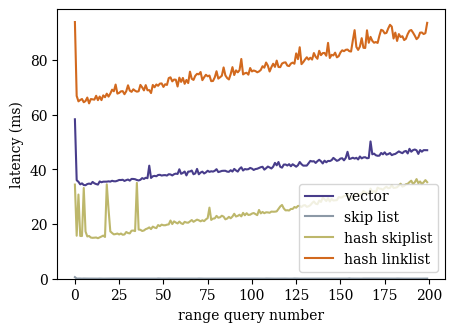

In [37]:
fig_size = (5, 3.5)

fig, ax = plt.subplots(figsize=fig_size)
ax.plot(
    vec_df.index[:range_queries],
    vec_df["TimeTaken"][:range_queries] / 1000,
    label="vector",
    **get_properties("Vector"),
)

ax.plot(
    skip_df.index[:range_queries],
    skip_df["TimeTaken"][:range_queries] / 1000,
    label="skip list",
    **get_properties("Skiplist"),
)

ax.plot(
    hash_skip_df.index[:range_queries],
    hash_skip_df["TimeTaken"][:range_queries] / 1000,
    label="hash skiplist",
    **get_properties("Hashskiplist"),
)

ax.plot(
    hash_link_df.index[:range_queries],
    hash_link_df["TimeTaken"][:range_queries] / 1000,
    label="hash linklist",
    **get_properties("Hashlinklist"),
)

ax.set_xlabel("range query number")
ax.set_ylabel("latency (ms)")
ax.set_ylim(bottom=0)
ax.legend()